In [18]:
# imports
import requests
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
import gmaps
from scipy.stats import linregress

# api keys
from config import wkey, epakey, censuskey, epaemail
# from config import gkey

# access maps
# gmaps.configure(api_key=gkey)

In [ ]:
# Abby's section starts here

In [2]:
# PurpleAir API

purple_air_df = pd.DataFrame()
purple_air_df['Index'] = [x for x in range(10000)]
purple_air_df = purple_air_df.set_index('Index')
purple_air_df['PLat'] = ""
purple_air_df['PLng'] = ""
purple_air_df['PLocation'] = ""
purple_air_df['PPM2_5'] = ""
purple_air_df['PTemp'] = ""
purple_air_df['PHumd'] = ""
purple_air_df['PPressure'] = ""
purple_air_df['PDataDate'] = ""
purple_air_df['PStats'] = ""

base_url = "https://www.purpleair.com/json"
response = requests.get(base_url).json()

for index, row in purple_air_df.iterrows():
    
    try:
        purple_air_df.loc[index, 'PLat'] = response['results'][index]['Lat']
        purple_air_df.loc[index, 'PLng'] = response['results'][index]['Lon']
        purple_air_df.loc[index, 'PLocation'] = response['results'][index]['DEVICE_LOCATIONTYPE']
        purple_air_df.loc[index, 'PPM2_5'] = response['results'][index]['PM2_5Value']
        purple_air_df.loc[index, 'PTemp'] = response['results'][index]['temp_f']
        purple_air_df.loc[index, 'PHumd'] = response['results'][index]['humidity']
        purple_air_df.loc[index, 'PPressure'] = response['results'][index]['pressure']
        purple_air_df.loc[index, 'PDataDate'] = response['results'][index]['LastSeen']
        purple_air_df.loc[index, 'PStats'] = response['results'][index]['Stats']
#         could also pull time since last seen and only grab values from the last hour
    except:
        pass

purple_air_df = purple_air_df.dropna()
purple_air_df

,PLat,PLng,PLocation,PPM2_5,PTemp,PHumd,PPressure,PDataDate,PStats
Index,,,,,,,,,
0,37.2756,-121.964,outside,5.72,62,50,1019.47,1580271144,"{""v"":5.72,""v1"":3.42,""v2"":3.29,""v3"":2.99,""v4"":2..."
1,37.2756,-121.964,,,,,,,
2,30.0538,-95.4946,outside,1.25,58,61,1010.62,1580271246,"{""v"":1.25,""v1"":1.94,""v2"":4.37,""v3"":7.05,""v4"":1..."
3,30.0538,-95.4946,,,,,,,
4,37.7224,-122.439,outside,7.9,55,55,994.27,1580271224,"{""v"":7.9,""v1"":3.81,""v2"":4.38,""v3"":4.62,""v4"":4...."
...,...,...,...,...,...,...,...,...,...
9995,40.5741,-74.4718,,,,,,,
9996,35.1345,-120.616,outside,3.91,64,52,1021.68,1580271160,"{""v"":3.91,""v1"":3.62,""v2"":3.07,""v3"":3.13,""v4"":3..."
9997,35.1345,-120.616,,,,,,,


In [3]:
mask = (purple_air_df['PDataDate'] != '') & (purple_air_df['PLocation']=='outside')
purple_air_df = purple_air_df.loc[mask,:]
purple_air_df = purple_air_df.astype({'PTemp':'int32'
                                      ,'PPM2_5':'double'
                                      ,'PHumd':'int'
                                      ,'PPressure':'double'
                                      ,'PDataDate':'int64'})
purple_air_df.dtypes

PLat          object
PLng          object
PLocation     object
PPM2_5       float64
PTemp          int32
PHumd          int64
PPressure    float64
PDataDate      int64
PStats        object
dtype: object

In [ ]:
response

In [5]:
purple_air_df = purple_air_df.loc[purple_air_df['PLocation']=='outside']

# get a dataframe masked for only the US locations
mask_us = (purple_air_df['PLat'] > 19.50) & (purple_air_df['PLat'] < 64.85) & (purple_air_df['PLng'] > -161.76) & (purple_air_df['PLng'] < -68.01)
US_purple_air_df = purple_air_df.loc[mask_us,:]

# get a dataframe masked for only MN locations and 'new' data (since Jan 1st, 2020)
mask_mn = (purple_air_df['PLat'] > 43.57) & (purple_air_df['PLat'] < 49.38) & (purple_air_df['PLng'] > -97.20) & (purple_air_df['PLng'] < -89.57) & (purple_air_df['PDataDate'] > 1577836800)
MN_purple_air_df = purple_air_df.loc[mask_mn,:]

MN_purple_air_df

,PLat,PLng,PLocation,PPM2_5,PTemp,PHumd,PPressure,PDataDate,PStats
Index,,,,,,,,,
246,44.9453,-93.2732,outside,27.88,28,56,991.74,1580271141,"{""v"":27.88,""v1"":28.51,""v2"":25.63,""v3"":23.01,""v..."
406,45.0005,-89.5995,outside,1.39,34,46,970.44,1580271147,"{""v"":1.39,""v1"":2.4,""v2"":1.59,""v3"":1.2,""v4"":0.8..."
958,44.9678,-93.66,outside,25.12,30,47,986.42,1580271131,"{""v"":25.12,""v1"":24.69,""v2"":22.83,""v3"":20.18,""v..."
1710,45.138,-93.26,outside,5.60,31,46,990.94,1580271137,"{""v"":5.6,""v1"":5.92,""v2"":5.62,""v3"":5.36,""v4"":4...."
2124,45.0595,-93.2941,outside,11.34,28,52,992.27,1580271197,"{""v"":11.34,""v1"":9.47,""v2"":8.58,""v3"":8.27,""v4"":..."
3278,44.9273,-91.382,outside,8.11,23,61,990.34,1580271179,"{""v"":8.11,""v1"":7.55,""v2"":7.02,""v3"":6.68,""v4"":6..."
3644,46.8111,-92.0597,outside,2.08,31,63,998.43,1580271171,"{""v"":2.08,""v1"":2.97,""v2"":3.12,""v3"":2.83,""v4"":1..."
4188,46.8075,-92.1426,outside,1.51,25,61,972.05,1580271173,"{""v"":1.51,""v1"":1.77,""v2"":1.78,""v3"":1.85,""v4"":1..."
4264,46.7008,-92.0428,outside,2.77,28,51,1001.05,1580271178,"{""v"":2.77,""v1"":2.95,""v2"":2.94,""v3"":2.61,""v4"":2..."


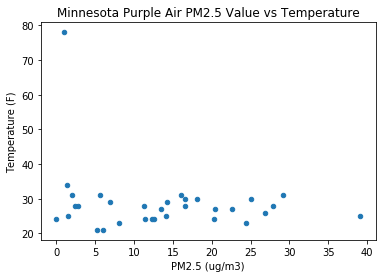

In [15]:
# Plotting data and checking for correlation
MN_purple_air_df.plot.scatter(x='PPM2_5', y='PTemp')
plt.xlabel("PM2.5 (ug/m3)")
plt.ylabel("Temperature (F)")
plt.title("Minnesota Purple Air PM2.5 Value vs Temperature")
plt.savefig("Images/PurpleAirMNPMvsTemp.png")
plt.show()

In [10]:
# Searching for outliers
quartiles = MN_purple_air_df['PTemp'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq - lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

MN_purple_air_df = MN_purple_air_df.reset_index(drop=True)

for x in range(len(MN_purple_air_df['PTemp'])):
    if (MN_purple_air_df.iloc[x, 4] > upper_bound) | (MN_purple_air_df.iloc[x,4] < lower_bound):
        print(f"found an outlier with value {MN_purple_air_df.iloc[x,4]}F and removing from dataframe.")
        nooutlier_data_df = MN_purple_air_df.drop([x])


found an outlier with value 78F and removing from dataframe.


The r-squared is: 0.015


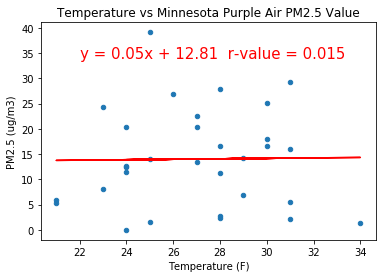

In [28]:
# Plotting data and checking for correlation
nooutlier_data_df.plot.scatter(y='PPM2_5', x='PTemp')
plt.ylabel("PM2.5 (ug/m3)")
plt.xlabel("Temperature (F)")
plt.title("Temperature vs Minnesota Purple Air PM2.5 Value")

y_values = nooutlier_data_df['PPM2_5']
x_values = nooutlier_data_df['PTemp']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept, 2)}  r-value = {round(rvalue,4)}"
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (22,34), fontsize=15, color='red')
print(f"The r-squared is: {round(rvalue,4)}")

plt.savefig("Images/PurpleAirMNPMvsTemp-nooutliers.png")
plt.show()

In [ ]:
# regression


In [ ]:
# EPA API
# sample data (lowest granularity date) by box (lat, long range)

lat_lng_range = 0.001

pollutant = '88101'
beginning_date = 20200126
end_date = beginning_date+1

# locations = purple_air_df[['PLat', 'PLng']]
# lat_range = pd.DataFrame()
# lat_range['Min Lat'] = locations.loc[:,'PLat'] - lat_lng_range
# lat_range['Max Lat'] = locations.loc[:,'PLat'] + lat_lng_range
# lng_range = pd.DataFrame()
# lng_range['Min Lng'] = locations.loc[:,'PLng'] - lat_lng_range
# lng_range['Max Lng'] = locations.loc[:,'PLng'] + lat_lng_range

# for minvalue, maxvalue in (zip(lat_range, lng_range)):
# #     for minlng, maxlng in lng_range:

#     base_url = "https://aps.eap.gov/data/api/sampleData/byBox?"
#     url = f'{base_url}email={epaemail}&key={epakey}&param={pollutant}&bdate={beginning_date}&edate={end_date}&minlat={minvalue}&maxlat={maxvalue}&minlon={minvalue}&maxlon={maxvalue}'
#     response = requests.get(url).json()
#     print(response)
#     #     try:
    

# minlat = 37.2756-0.001
# maxlat = 37.2756+0.001
# minlng = -121.964-0.001
# maxlng = -121.964+0.001

minlat = 46.7296
maxlat = 46.7396
minlng = 94.6859
maxlng = 94.6959

epakey = 'amberhawk52'
epaemail = 'helloniharika@gmail.com'

base_url = "https://aps.eap.gov/data/api/sampleData/byBox?"
url = f'{base_url}email={epaemail}&key={epakey}&param={pollutant}&bdate={beginning_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlng}&maxlon={maxlng}'
response = requests.get(url).json()
print(response)
        

# ex: https://aqs.epa.gov/data/api/sampleData/byBox?email=test@aqs.api&key=test&param=44201&bdate=20150501&edate=20150502&minlat=33.3&maxlat=33.6&minlon=-87.0&maxlon=-86.7
# https://aqs.epa.gov/data/api/sampleData/byBox?email=abby.lemon22@gmail.com&key=indigogoose44&param=88101&bdate=20200126&edate=20200127&minlat=37.2746&maxlat=37.2766&minlon=-121.963&maxlon=-121.965

In [29]:
# EPA API
# EPA Air Quality Section
# yearly data by state (minnesota)

pm2_5_1Hour = []
pm2_5_24HourBulk = []
pm2_5_24Hour = []
year_list = []
years = [x for x in range(1990,2020)]

email = 'abby.lemon22@gmail.com'
state_code = "27" 
# PM2.5 - Local Conditions
pollutant = "88101"

for year in years:
    beginging_date = f"{year}0502"
    end_date = f"{year}0502"
    base_url = "https://aqs.epa.gov/data/api/annualData/byState?"
    url = f'{base_url}email={email}&key={epakey}&param={pollutant}&bdate={beginging_date}&edate={end_date}&state={state_code}'
    response = requests.get(url).json()
    try:
        pm2_5_1Hour.append(response['Data'][0]['arithmetic_mean'])
        pm2_5_24HourBulk.append(response['Data'][1]['arithmetic_mean'])
        pm2_5_24Hour.append(response['Data'][5]['arithmetic_mean'])
        year_list.append(response['Data'][0]['year'])
    except:
        print(f"No data found, skip {year}.")
        pass



No data found, skip 1990.
No data found, skip 1991.
No data found, skip 1992.
No data found, skip 1993.
No data found, skip 1994.
No data found, skip 1995.
No data found, skip 1996.
No data found, skip 1997.
No data found, skip 1998.


In [ ]:
pm2_5_df = pd.DataFrame([year_list,pm2_5_1Hour,pm2_5_24HourBulk,pm2_5_24Hour]).T
pm2_5_df = pm2_5_df.rename(columns={0:'Year',
                                    1:'PM 2.5 1 hour',
                                    2:'PM 2.5 24 hour bulk',
                                    3:'PM 2.5 24 hour'
})
pm2_5_df['Year'] = pm2_5_df['Year'].astype(int)
# pm2_5_df['PM 2.5'] = pm2_5
pm2_5_df.to_csv("Resource/EPAData_per_year_MN.csv")
pm2_5_df

In [ ]:
pm_plot = pm2_5_df.plot(kind='line', x='Year',y=['PM 2.5 1 hour','PM 2.5 24 hour bulk','PM 2.5 24 hour'],grid=True)
plt.ylabel('PM2.5 (ug/m3)')
plt.title("Year vs Annual Mean PM2.5 Value")
plt.savefig("Images/YearvsAnnualMeanPM2_5Value.png")
plt.show()

In [ ]:
# Census API
# Thinking I might not need to pull Census data.

c = Census(censuskey, year=2018)
# need to get this working for 2019, what is the difference between 2010 and 2019?
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)
census_pd

In [ ]:
# Abby's section ends here

In [ ]:
# Alan's section starts here

In [ ]:
# Alan's section ends here

In [ ]:
# Brandon's section starts here

In [ ]:
# Brandon's section ends here